In [61]:
import json
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from src.entities.Issue import Issue

In [43]:
top_50 = pd.read_csv("top-50.csv")
repos = top_50['repo_name'].to_numpy()

In [82]:
all_repos = []

for repo in repos:
    owner, name = repo.split("/")
    is_path = False
    for file in os.listdir(f"../code/data/issue-history/"):
        filename = os.fsdecode(file)
        if f"{owner.lower()}--{name.lower()}" in filename:
            is_path = True
            all_repos.append(repo)
            break
    if not is_path:
        print(f"Missing {repo}")

Missing vuejs/vue
Missing angular/angular.js
Missing Dogfalo/materialize
Missing webpack/webpack
Missing Semantic-Org/Semantic-UI
Missing babel/babel
Missing nwjs/nw.js
Missing jekyll/jekyll
Missing scikit-learn/scikit-learn
Missing kubernetes/kubernetes
Missing ariya/phantomjs
Missing angular/material
Missing Bilibili/ijkplayer
Missing NativeScript/NativeScript
Missing TryGhost/Ghost
Missing syncthing/syncthing
Missing adobe/brackets
Missing balderdashy/sails
Missing nolimits4web/Swiper
Missing chartjs/Chart.js
Missing Leaflet/Leaflet
Missing mozilla/pdf.js
Missing emberjs/ember.js
Missing prometheus/prometheus


In [94]:
treated = ['FreeCodeCamp/FreeCodeCamp',
 'facebook/react-native',
 'tensorflow/tensorflow',
 'atom/atom',
 'Microsoft/vscode',
 'angular/angular',
 'golang/go',
 'rails/rails',
 'mrdoob/three.js',
 'Microsoft/TypeScript',
 'electron/electron',
 'ansible/ansible',
 'grafana/grafana',
 'ant-design/ant-design',
 'ampproject/amphtml',
 'fastlane/fastlane',
 'Automattic/wp-calypso',
 'spring-projects/spring-boot',
 'dotnet/roslyn']

control = ['facebook/react',
 'twbs/bootstrap',
 'apple/swift',
 'grpc/grpc',
 'spring-projects/spring-framework',
 'symfony/symfony']

In [104]:
def find_filename(repo):
    owner, name = repo.split("/")

    for file in os.listdir(f"../code/data/issue-history/"):
        filename = os.fsdecode(file)
        if f"_{owner.lower()}--{name.lower()}_" in filename:
            return f"../code/data/issue-history/{filename}"
    
    raise ValueError(f"Missing {repo}")

In [105]:
def get_ttr(issue):
    if not issue['state'] == 'closed':
        return None
    if issue['closed_at'] is None or issue['created_at'] is None:
        return None
    diff = (pd.to_datetime(issue['closed_at']).tz_localize(None) - 
            pd.to_datetime(issue['created_at']).tz_localize(None))
    return int(diff.total_seconds() / 60)

In [106]:
issue_dict = {}

for repo in all_repos:
    issue_dict[repo] = {}
    with open(find_filename(repo), "r") as f:
        for line in f.readlines():
            issue = json.loads(line)['data']
            if (pd.to_datetime('2016-01-01') <= 
            pd.to_datetime(issue['created_at']).tz_localize(None) <=
            pd.to_datetime('2016-06-30')):
                issue_dict[repo][pd.to_datetime(issue['created_at'])] = {
                    "title": issue['title'],
                    "comments": issue['comments'],
                    "ttr": get_ttr(issue)
                }
        print(f"finished {repo}")

finished FreeCodeCamp/FreeCodeCamp
finished facebook/react
finished facebook/react-native
finished tensorflow/tensorflow
finished twbs/bootstrap
finished apple/swift
finished atom/atom
finished Microsoft/vscode
finished angular/angular
finished golang/go
finished rails/rails
finished mrdoob/three.js
finished Microsoft/TypeScript
finished electron/electron
finished ansible/ansible
finished grafana/grafana
finished ant-design/ant-design
finished ampproject/amphtml
finished fastlane/fastlane
finished Automattic/wp-calypso
finished grpc/grpc
finished spring-projects/spring-boot
finished spring-projects/spring-framework
finished symfony/symfony
finished dotnet/roslyn


In [107]:
issue_dd_df = {}

for repo in issue_dict:
    issues = issue_dict[repo]
    ttr_data = {k: v['ttr'] for k, v in issues.items() if v['ttr'] is not None}
    series = pd.Series(list(ttr_data.values()), index=list(ttr_data.keys()))
    series.index = pd.to_datetime(series.index, utc=True)
    data = series.resample('Q').mean()
    issue_dd_df[repo] = data.values

In [108]:
ys = []
ds = []

for repo in issue_dd_df:
    ys.append(issue_dd_df[repo][1] - issue_dd_df[repo][0])
    ds.append(1 if repo in treated else 0)

In [109]:
df = pd.DataFrame({"y": ys, "d": ds}, index=list(issue_dd_df.keys()))

In [116]:
def get_repo_stats(row):
    owner, name = row.name.split("/")
    with (open(f"repo-data/{owner}--{name}.log")) as f:
        data = json.load(f)
        return data['size'], data['forks_count'], data['watchers'], (pd.to_datetime("2016-02-17") - pd.to_datetime(data['created_at']).tz_localize(None)).days

In [120]:
df['size'], df['forks'], df['watchers'], df['age'] = zip(*df.apply(get_repo_stats, axis=1))

In [165]:
df = df.drop(["spring-projects/spring-framework"])

In [166]:
df[df['d'] == 0]

,y,d,size,forks,watchers,age
facebook/react,38236.098476,0,396651,44819,219590,998
twbs/bootstrap,-13772.422263,0,239122,78303,166972,1663
grpc/grpc,58308.378755,0,504780,10286,40324,435
symfony/symfony,-4871.779510,0,271408,9322,29132,2234


In [167]:
df[df['d'] == 0]['y'].mean()

19475.068864541354

In [168]:
from doubleml import DoubleMLData, DoubleMLDID

dml_data = DoubleMLData(df, y_col='y', d_cols='d', x_cols=['size', 'forks', 'watchers', 'age'])

In [169]:
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

n_estimators = 30
ml_g = RandomForestRegressor(n_estimators=n_estimators)
ml_m = RandomForestClassifier(n_estimators=n_estimators)

In [170]:
dml_did = DoubleMLDID(dml_data,
                      ml_g=ml_g,
                      ml_m=ml_m,
                      score='observational',
                      in_sample_normalization=True,
                      n_folds=5)

dml_did.fit()
print(dml_did)

================== DoubleMLDID Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['size', 'forks', 'watchers', 'age']
Instrument variable(s): None
No. Observations: 23

------------------ Score & algorithm ------------------
Score function: observational
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(n_estimators=30)
Learner ml_m: RandomForestClassifier(n_estimators=30)
Out-of-sample Performance:
Learner ml_g0 RMSE: [[35990.99173818]]
Learner ml_g1 RMSE: [[65661.91322341]]
Learner ml_m RMSE: [[0.43856651]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
           coef       std err         t     P>|t|          2.5 %       97.5 %
d -46946.303536  27241.274229 -1.723352  0.084825 -100338.219918  6

/opt/homebrew/anaconda3/envs/mlproj/lib/python3.11/site-packages/doubleml/_utils_checks.py:204: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=30) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


In [111]:
import subprocess

for repo in all_repos:
    owner, name = repo.split("/")
    cmd = f"curl https://api.github.com/repos/{repo}"
    with (open(f"repo-data/{owner}--{name}.log", "w")) as f:
        subprocess.run(cmd, stdout=f, shell=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7526  100  7526    0     0  19130      0 --:--:-- --:--:-- --:--:-- 19101
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6646  100  6646    0     0  27940      0 --:--:-- --:--:-- --:--:-- 28042
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7013  100  7013    0     0  29225      0 --:--:-- --:--:-- --:--:-- 29343
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7122  100  7122    0     0  34999      0 --:--:-- --:--:-- --:--:-- 35083
  % Total    % Received % Xferd  Average Speed   Tim

In [65]:
issue_plot = {k: v.getTimeToResolution() for k, v in issue_dict.items() if v.getTimeToResolution() is not None}

In [155]:
issue_plot = {k: v['ttr'] for k, v in issue_dict['spring-projects/spring-framework'].items() if v['ttr'] is not None}

In [162]:
series = pd.Series(list(issue_plot.values()), index=list(issue_plot.keys()))
series.index = pd.to_datetime(series.index, utc=True)
data = series.resample('M').mean()

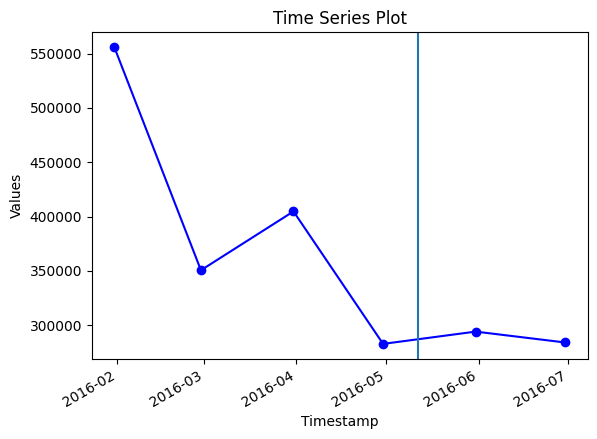

In [163]:
import matplotlib.pyplot as plt
from datetime import datetime

# data = {}
# for i, (time, _) in enumerate(first_adoption_plot.items()):
#     data[time] = i

timestamps = list(data.index)
values = list(data.values)

# Plot the data
plt.plot(timestamps, values, marker='o', linestyle='-', color='b')
plt.axvline(x=pd.to_datetime('2016-05-11 15:30:25'))

# Optionally, format the x-axis as dates
plt.gcf().autofmt_xdate()

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Time Series Plot')

# Show the plot
plt.show()